## 302.2. Stellar multi-color photometry

<div style="max-width:300px; float: left; margin-right: 1em">

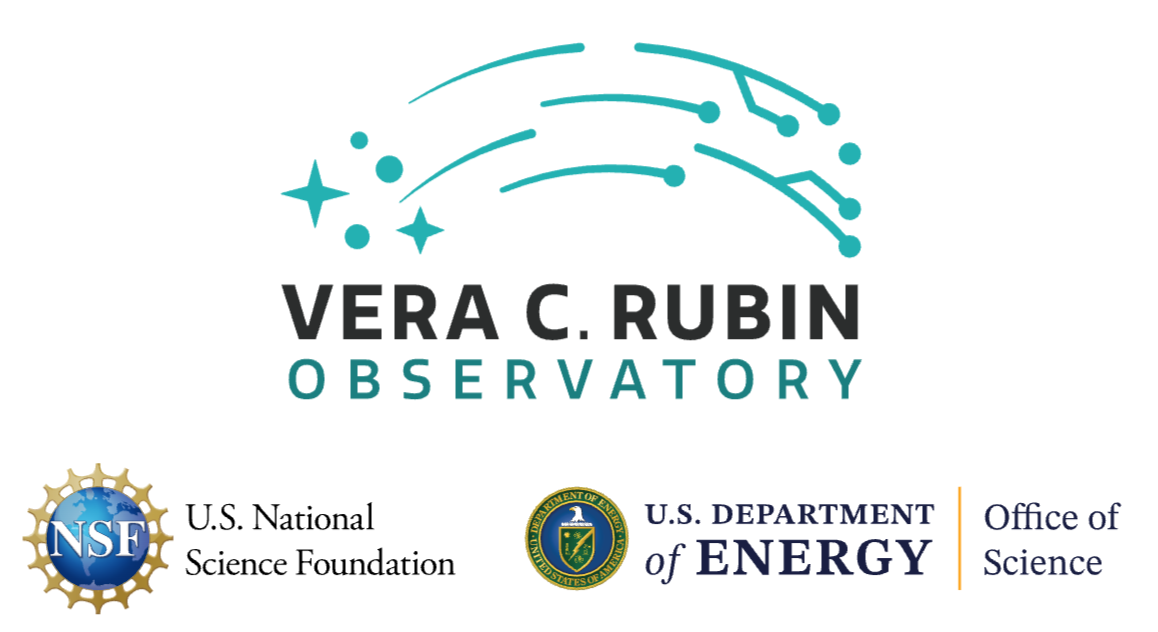

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2026-02-20 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>
DOI: <a href="https://doi.org/10.11578/rubin/dc.20250909.20">10.11578/rubin/dc.20250909.20</a> <br>

**Learning objective:** To learn how to explore stellar color-magnitude and color-color diagrams using LSSTComCam Fornax dSph field from DP 1.

**LSST data products:** `Object`

**Packages:** `lsst.rsp.get_tap_service`

**Credit:**
Originally developed by the Rubin Community Science team. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks. 

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook examines the DP1 stellar photometry in the Fornax dSph field focusing on the distributions of stars in color-magnitude and color-color diagrams (CMDs and CCDs, respectively).

Constructing a Hertzsprung–Russell (H–R) diagram, by plotting stellar luminosity or absolute magnitude against surface temperature or spectral type, reveals distinct evolutionary phases, ranging from the hydrogen-burning main sequence to the evolved giant branches. While these fundamental parameters are traditionally derived via spectroscopy, astronomers leverage multi-band photometry to approximate these physical quantities through observed magnitudes and colors. Analyzing CMDs, as the photometric counterpart to the H-R diagram, enables the efficient characterization of large, resolved stellar populations and provides a robust framework for age and metallicity determination through isochrone synthesis.

CCDs are one of the primary diagnotic frameworks to decouple the intrinsic parameters of a stellar populations. These diagrams help identify key properties of stars—such as temperature, chemical makeup, surface gravity, and the effects of dust—based on how those traits influence a star’s color. The CCD presented in this tutorial uses the r–i and g–r color indices to highlight differences in stellar properties. These combinations are sensitive to how stars emit light across different filters, making them effective for identifying patterns and classifying stars.

The Fornax dSph is a satellite of the Milky Way known. The LSSTComCam field targeting this galaxy is centered at (RA, Dec) = (40.080, -34.450) degrees and is representative of relatively crowded regions that LSST will encounter in the Milky Way.

**Related tutorials:** See the 300-level DP1 tutorials on stellar PSF photometry, the Fornax dSph field exploration, and the Milky Way foreground dust correction.

### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), 
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>;
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>), and the `SkyCoord` class from <a href="https://docs.astropy.org/en/stable/coordinates/index.html">astropy.cooridates</a>.

From the LSST pacakge (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>), import the RSP Table Access Protocol (TAP) service and the `DustValues` class from the `rubin_sim` package (<a href="https://rubin-sim.lsst.io/index.html">rubin_sim</a>).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u
import os

from lsst.rsp import get_tap_service
from rubin_sim.phot_utils import DustValues

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Define a circular region with a 1-degree radius centered on the "low-latitude field" RubinSV_95_-25. (coordinates in degrees).

In [ ]:
ra_cen = 40.080
dec_cen = -34.450
radius = 1.0

Set the environment variable RUBIN_SIM_DATA_DIR to /rubin/rubin_sim_data to make the current rubin_sim throughput data available.

In [ ]:
os.environ['RUBIN_SIM_DATA_DIR'] = '/rubin/rubin_sim_data'

List bands that are used in this notebook.

In [ ]:
bands = "gri"

Set font sizes globally for all subsequent matplotlib figures in this notebook.

In [ ]:
plt.rcParams["font.size"] = 15
plt.rcParams["figure.titlesize"] = 15
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlesize"] = 12

## 2. Construct an CMD

Retrieve the necessary PSF photometry to select stars for which the calibrated relations can be applied, correct for Milky Way foreground dust, and transform the dust-corrected photometry to the SDSS system.

### 2.1. Query for point-like objects

Query the `Object` table in the Fornax dSph field for coordinates, PSF photometry in $gri$, and $E(B-V)$ values. Restrict to point sources (`refExtendedness` = 0).

In [ ]:
query = """
        SELECT coord_ra, coord_dec, g_psfMag, r_psfMag, i_psfMag, ebv
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {}, {}, {})) = 1
        AND refExtendedness = 0
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Fetch the results, store them as a table.

In [ ]:
assert job.phase == 'COMPLETED'
df = job.fetch_result().to_table()

### 2.2. Apply dust correction

The `DustValues().r_x` attribute provides the extinction coefficients for the Rubin filters. These coefficients are derived from the CCM89 extinction law ([Cardelli, Clayton, & Mathis 1989](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract)), assuming a flat spectral energy distribution and a default total-to-selective extinction ratio of 3.1, representative of the diffuse Milky Way interstellar medium. Apply dust correction in each filter and save the dust-corrected magnitudes as new columns in the `df` table.

In [ ]:
R_band = DustValues().r_x
A_band = {band: R_band[band] * df['ebv'] for band in bands}
for band in bands:
    df[f"{band}_psfMag0"] = df[f"{band}_psfMag"] - A_band[band]

Compute the average dust correction in $r$ and $g-r$ to plot the reddening vector in the CMDs below.

In [ ]:
shift_in_r = np.ma.median(A_band['r'])
shift_in_gr = np.ma.median(A_band['g'] - A_band['r'])

print(f"Average extinction in r: {shift_in_r: .3f} mag")
print(f"Average reddening in g-r: {shift_in_gr: .3f} mag")

### 2.3. Impact of dust correction on CMD

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
plt.subplots_adjust(right=0.9)

data_configs = [
    (df['g_psfMag'] - df['r_psfMag'], df['r_psfMag'],
     'g - r', 'r'),
    (df['g_psfMag0'] - df['r_psfMag0'], df['r_psfMag0'],
     r'$g_0 - r_0$', r'$r_0$')
]

for ax, (x, y, xl, yl) in zip(axes, data_configs):
    hb = ax.hexbin(x, y, gridsize=200, extent=[-1, 2, 15, 27], 
                   cmap='viridis', norm=LogNorm(vmax=70))
    ax.set_xlim(-1, 2)
    ax.set_ylim(27, 15)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)

axes[0].arrow(-0.9, 16, shift_in_gr*10, shift_in_r*10, color='red', 
              head_width=0.2, length_includes_head=True)
axes[0].text(-0.9, 15.8, 'Avg. reddening x 10', color='red')

cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label="Number of stars")

plt.show()

> **Figure 1:** ($g-r$, $r$) CMDs of the Fornax dSph field before Milky Way foreground correction (left panel) vs. after (right panel). Both panels use the same color scale. Due to the minimal foreground extinction toward the Fornax dSph, the reddening vector, which is derived by scaling the average $A_r$ and $E(g−r)$ values by a factor of 10, is exaggerated to ensure the directional shift is clearly visible on the CMD.

## 3. Spatial distribution of stellar populations

Select RGB, RC, HB, MSTO, BP, and MW stars from the CMD and look at their spatial distribution.

## 4. Stellar distribution in CCDs 